In [ ]:
# faiss-gpu: a vector database from facebook
%pip -q install datasets transformers sentence_transformers faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 39.8 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import login

login()

In [ ]:
from datasets import load_dataset

dataset = load_dataset('garage-bAInd/Open-Platypus')
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/24926 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'data_source'],
        num_rows: 24926
    })
})

In [ ]:
dataset['train'].to_pandas()

,input,output,instruction,data_source
0,,To find the probability of the spinner landing...,A board game spinner is divided into three par...,MATH/PRM-800K
1,,"I need to choose 6 people out of 14, and the o...",My school's math club has 6 boys and 8 girls. ...,MATH/PRM-800K
2,,First we count the number of all 4-letter word...,How many 4-letter words with at least one cons...,MATH/PRM-800K
3,,She can do this if and only if at least one of...,Melinda will roll two standard six-sided dice ...,MATH/PRM-800K
4,,Think of the problem as a sequence of H's and ...,"Let $p$ be the probability that, in the proces...",MATH/PRM-800K
...,...,...,...,...
24921,,There are several formulas that generate all p...,Can we find a formula to generate all prime nu...,guanaco
24922,,"Sure, here are some of the best universities:\...",What are some of the best university's for stu...,guanaco
24923,,[Enter stage left]\n\nFirst Citizen: Good morr...,Write me a SPL (Shakespeare Programming Langua...,guanaco
24924,,That's a very thoughtful idea! Here are some s...,Hi. I want to make an embossed picture for my ...,guanaco


In [ ]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

tokenizer = AutoTokenizer.from_pretrained('meta-llama/Meta-Llama-3-8B-Instruct')
# tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]
# instruction_token_counts
# output_token_counts
# combined_token_counts

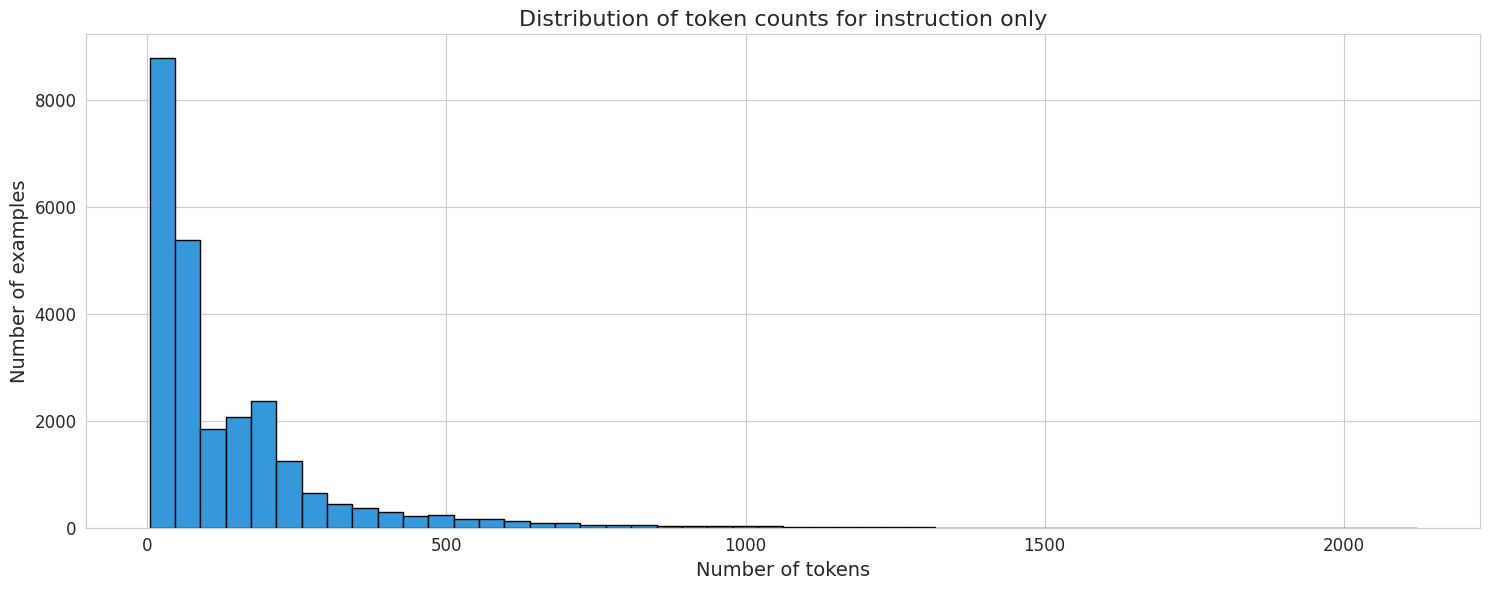

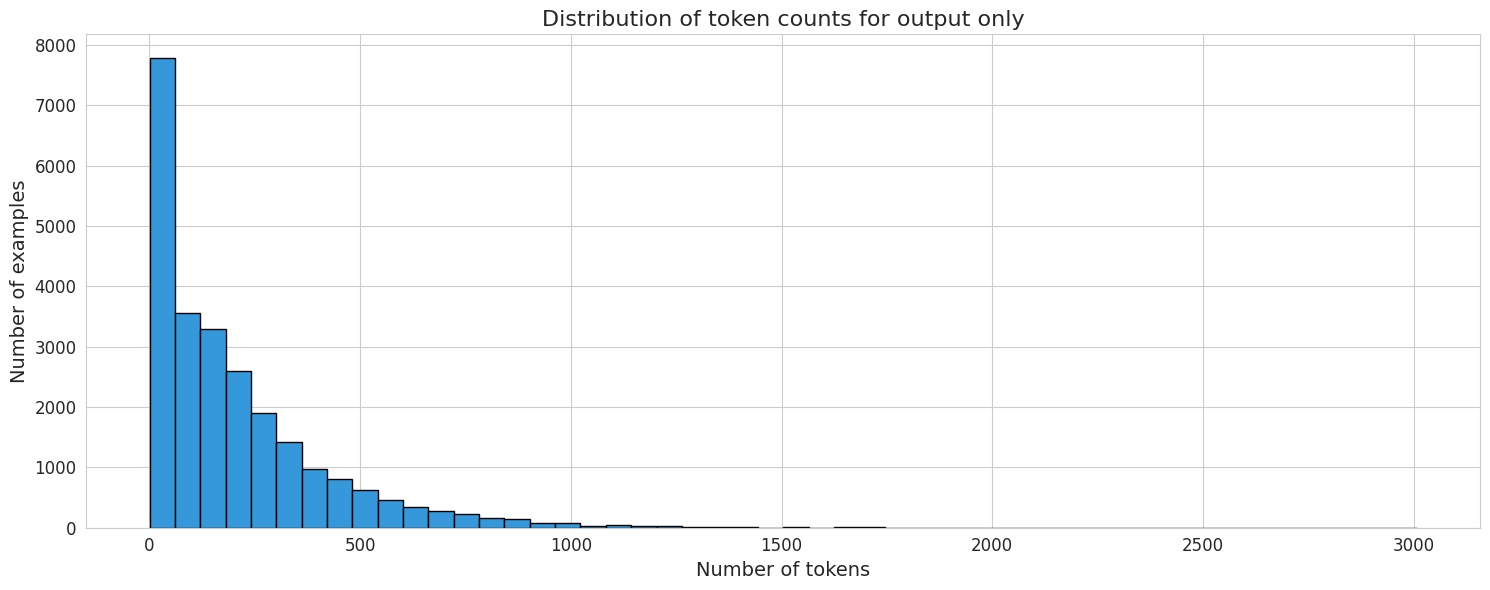

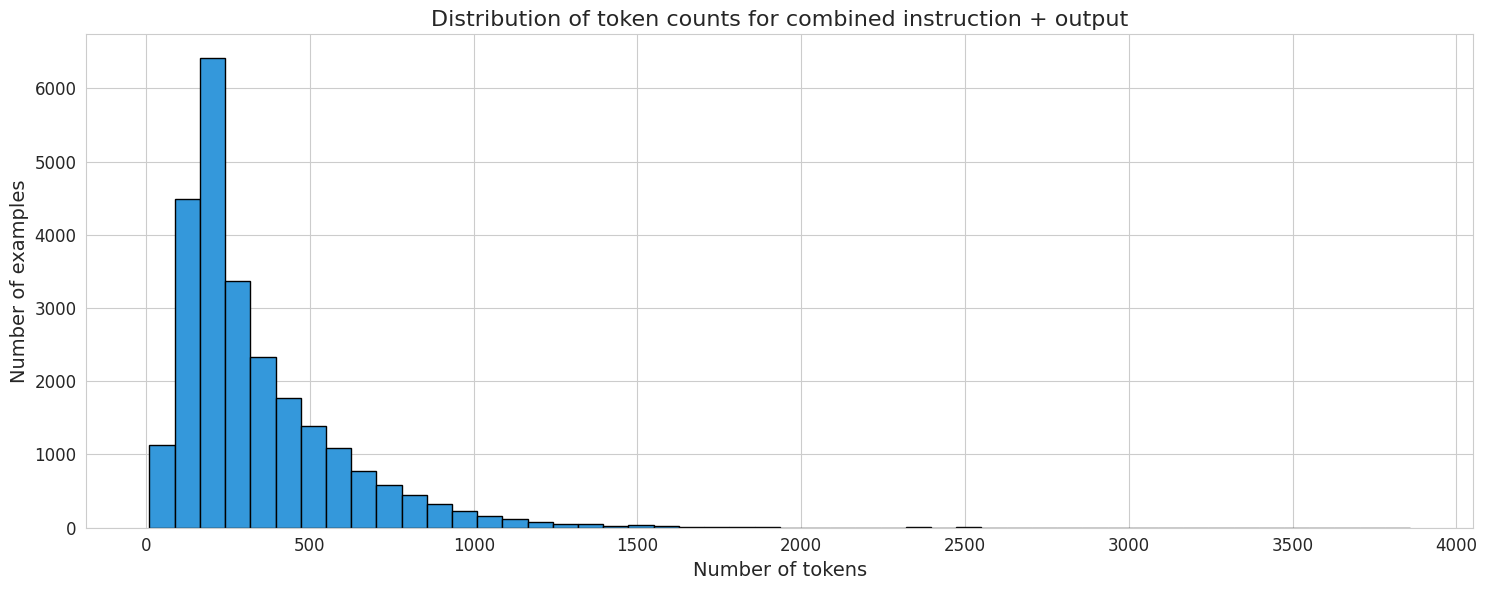

In [ ]:
# Helper function to plot the distributions
def plot_distribution(token_counts, title):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 6))
    plt.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

In [ ]:
valid_indices = [i for i, count in enumerate(combined_token_counts) if count <= 2048]
print(len(valid_indices))
print(len(dataset['train']) - len(valid_indices))

24911
15


In [ ]:
dataset['train'] = dataset['train'].select(valid_indices)

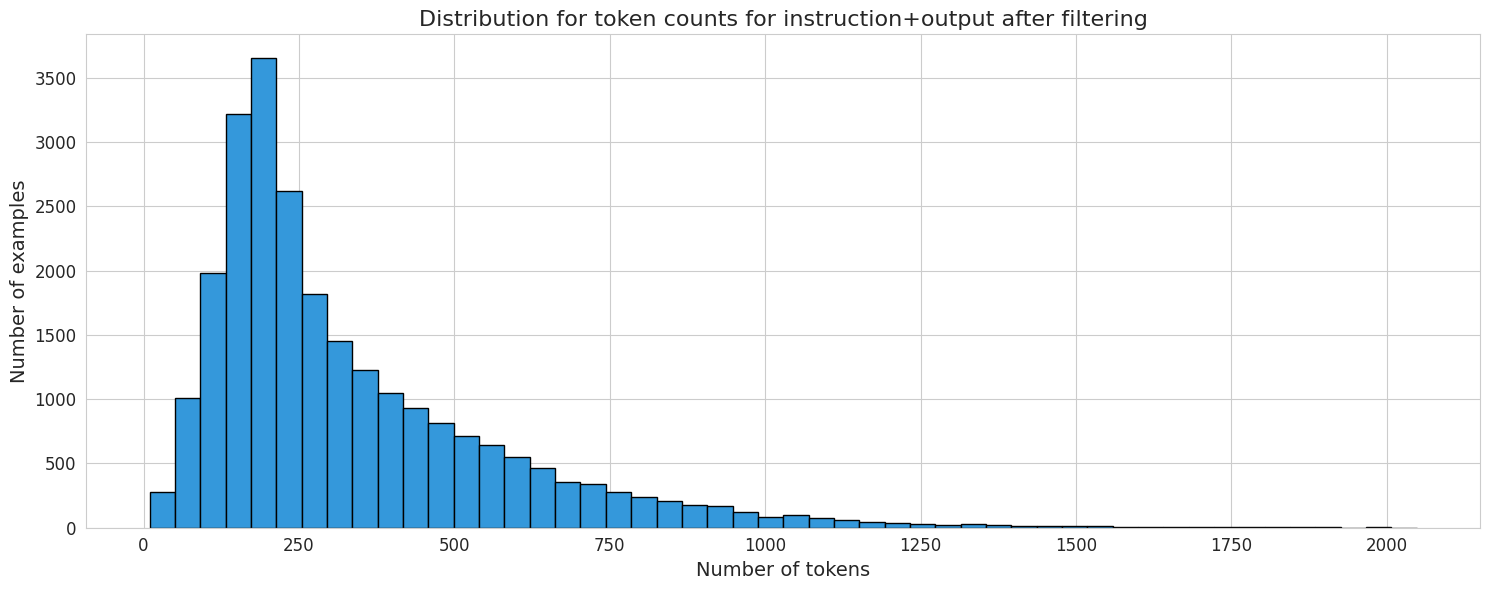

In [ ]:
token_counts = [combined_token_counts[i] for i in valid_indices]
plot_distribution(token_counts, "Distribution for token counts for instruction+output after filtering")

In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
from datasets import Dataset, DatasetDict
from tqdm.autonotebook import tqdm
import numpy as np

def deduplicate_dataset(dataset: Dataset, model: str, threshold: float):
    sentence_model = SentenceTransformer(model)
    outputs = [example["output"] for example in dataset['train']]

    print("Converting text to embeddings...")
    embeddings = sentence_model.encode(outputs, show_progress_bar=True)
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    index.add(normalized_embeddings)

    print("Filtering out near-duplicates...")
    D, I = index.search(normalized_embeddings, k=2)
    to_keep = []

    for i in tqdm(range(len(embeddings)), desc="Filtering"):
        # If the second closest vector (D[i, 1]) has cosine similarity above the threshold
        if D[i, 1] >= threshold:
            # Check if either the current item or its nearest neighbor is already in the to_keep list
            nearest_neighbor = I[i, 1]
            if i not in to_keep and nearest_neighbor not in to_keep:
                # If not, add the current item to the list
                to_keep.append(i)
        else:
            # If the similarity is below the threshold, always keep the current item
            to_keep.append(i)

    dataset = dataset['train'].select(to_keep)
    return DatasetDict({"train": dataset})

deduped_dataset = deduplicate_dataset(dataset, "thenlper/gte-large", 0.95)

Converting text to embeddings...


Batches:   0%|          | 0/779 [00:00<?, ?it/s]

Filtering out near-duplicates...


Filtering:   0%|          | 0/24911 [00:00<?, ?it/s]

In [ ]:
print(f"Number of samples in the original dataset: {len(dataset['train'])}") # original dataset
print(f"Number of samples in the deduped dataset: {len(deduped_dataset['train'])}") # deduped dataset
print(f"Number of samples that were removed: {len(dataset['train']) - len(deduped_dataset['train'])}") # the number of the samples that are removed

Number of samples in the original dataset: 24911
Number of samples in the deduped dataset: 20540
Number of samples that were removed: 4371


In [ ]:
# choosing the samples with the most tokens, as the dataset is still large and need to be pruned
# k: to know how many we want to have
def get_top_k_rows(dataset, token_counts, k):
    sorted_indices = sorted(range(len(token_counts)), key= lambda i: token_counts[i], reverse=True) # sorting by descending order
    top_k_indices = sorted_indices[:k] # keep just those top k
    top_k_data = {
        "instruction": [dataset['train'][i]["instruction"] for i in top_k_indices], # for loop to select all the samples in the sortde_indices to keep 1000 of them
        "output": [dataset['train'][i]["output"] for i in top_k_indices],
    }
    return Dataset.from_dict(top_k_data)

instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]
# instruction_token_counts
# output_token_counts
# combined_token_counts

k = 5000
top_k_dataset = get_top_k_rows(dataset, combined_token_counts, k)

dataset = DatasetDict({"train": top_k_dataset}) # save it as a dictionary to make sure we still have it as train split - nor much important

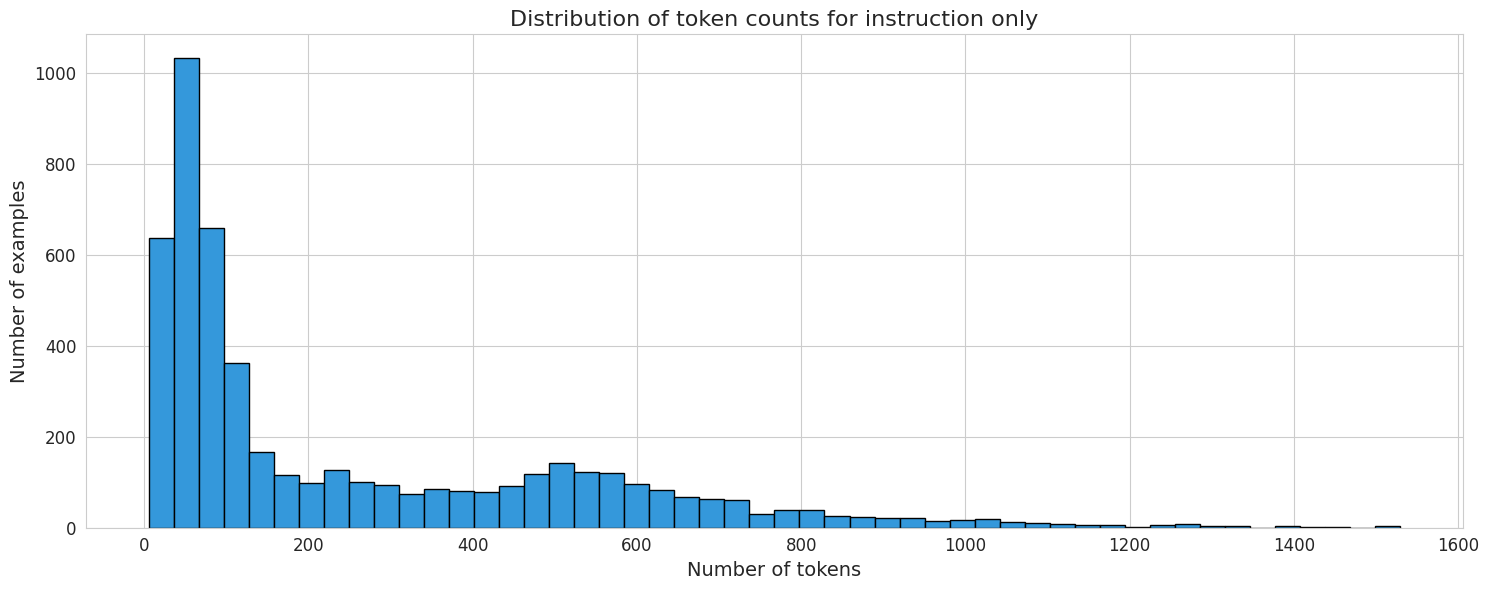

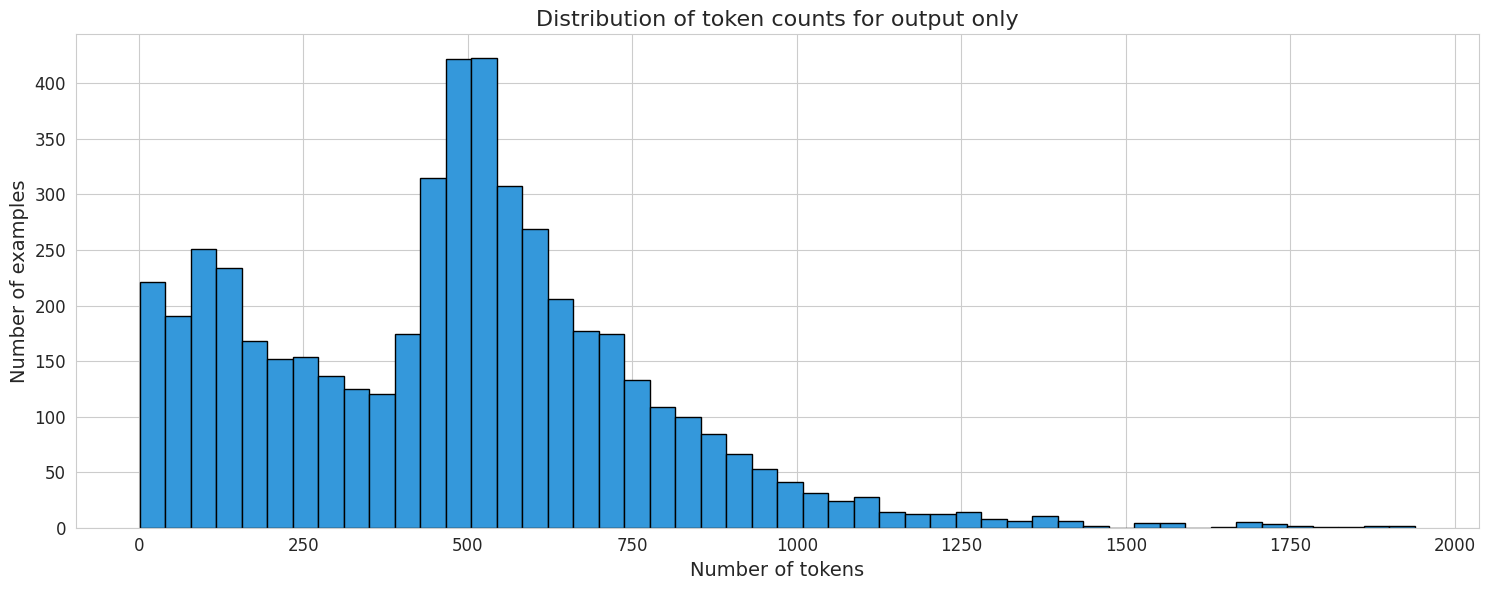

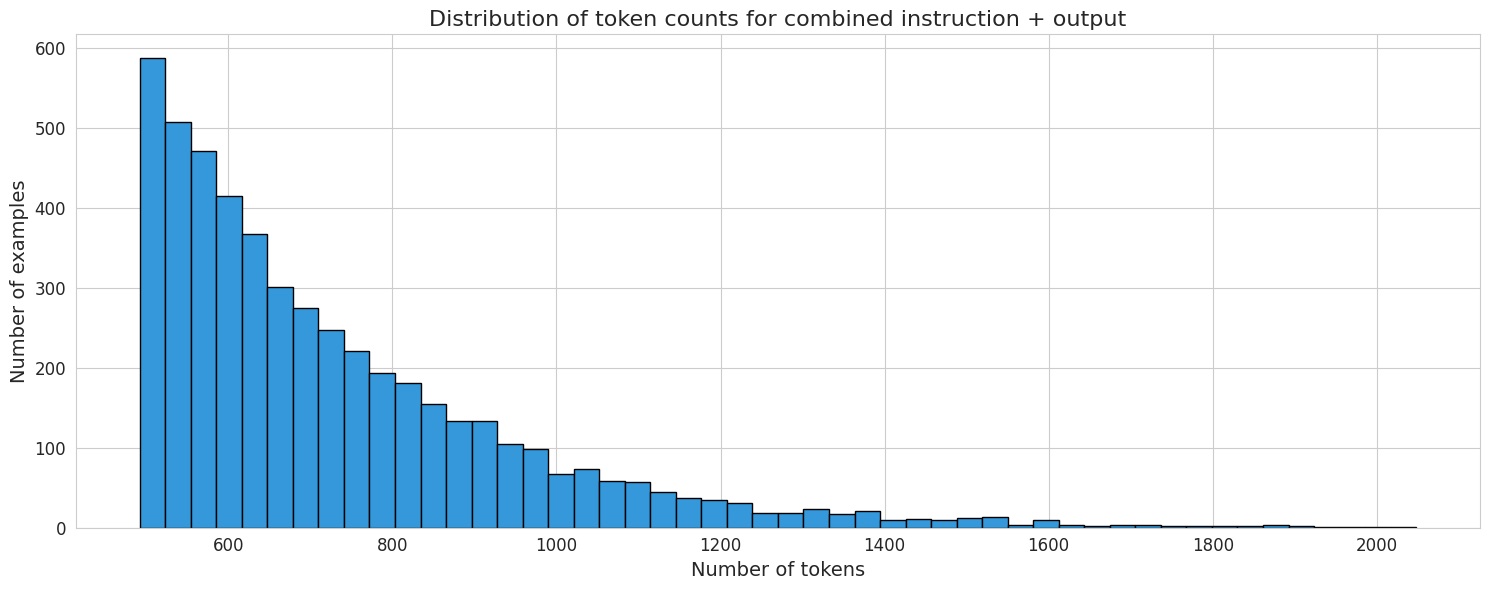

In [ ]:
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

# Plot the new distribution of token counts after top k sampling
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

In [ ]:
# to check out the samples
dataset['train'].to_pandas()

,instruction,output
0,"User : Hi dear \nAgent : helo , can ai help yo...","I'm sorry, I don't understand your intention. ..."
1,A regular hexagon with center at the origin in...,We can compute that the side length of the hex...
2,"Given triangle $ABC,$ there exists a unique po...",From the equation $AB^2 + AP^2 + BP^2 = AC^2 +...
3,Let $P$ be the plane passing through the origi...,Let $\mathbf{v} = \begin{pmatrix} x \\ y \\ z ...
4,"Let\n$$p(x,y) = a_0 + a_1x + a_2y + a_3x^2 + a...","Observe that \begin{align*}\np(0,0) &= a_0 = ..."
...,...,...
4995,"Oswald owned an old, unoccupied, and extremely...",A
4996,"An electron (mass $m$, charge $e$ ) moves in a...",In uniform magnetic field $B$ the motion of an...
4997,Your firm is trying to decide whether to buy a...,0.0758
4998,What is the minimum kinetic energy in MeV of a...,0.08


In [ ]:
def chat_template(example):
    example["instruction"] = f"### Instruction: \n{example['instruction']}\n\n### Response:\n"
    return example

dataset = dataset.map(chat_template)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
dataset['train'].to_pandas()

,instruction,output
0,### Instruction: \nUser : Hi dear \nAgent : he...,"I'm sorry, I don't understand your intention. ..."
1,### Instruction: \nA regular hexagon with cent...,We can compute that the side length of the hex...
2,"### Instruction: \nGiven triangle $ABC,$ there...",From the equation $AB^2 + AP^2 + BP^2 = AC^2 +...
3,### Instruction: \nLet $P$ be the plane passin...,Let $\mathbf{v} = \begin{pmatrix} x \\ y \\ z ...
4,"### Instruction: \nLet\n$$p(x,y) = a_0 + a_1x ...","Observe that \begin{align*}\np(0,0) &= a_0 = ..."
...,...,...
4995,"### Instruction: \nOswald owned an old, unoccu...",A
4996,"### Instruction: \nAn electron (mass $m$, char...",In uniform magnetic field $B$ the motion of an...
4997,### Instruction: \nYour firm is trying to deci...,0.0758
4998,### Instruction: \nWhat is the minimum kinetic...,0.08


In [ ]:
# just push the dataset to the huggingface hub
dataset.push_to_hub("mini-platypus-5k", token=hf_token)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/488 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/nmdr/mini-platypus-5k/commit/d44cbb97fcdc33bb12e8657c317a9316a16b2ce1', commit_message='Upload dataset', commit_description='', oid='d44cbb97fcdc33bb12e8657c317a9316a16b2ce1', pr_url=None, pr_revision=None, pr_num=None)